First set up for using Schnet on our crystal data.

In [8]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import schnetpack as spk
from schnetpack.data import ASEAtomsData, BaseAtomsData, AtomsDataFormat, AtomsDataModule
import schnetpack.transform as trn
import torch
import torchmetrics
import pytorch_lightning as pl
import pickle
# from pymatgen.io.ase import AseAtomsAdaptor as pase

In [9]:
torch.cuda.is_available()

True

In [10]:
# with open("positive_data/dataUnder30Fepa", "wb") as fp:
#     pickle.dump(testfepa, fp)
with open("data_for_dev_try/pdataUnder30Fepa", "rb") as fp:
# with open("positive_data/dataUnder30Fepa", "rb") as fp:
    testfepa = pickle.load(fp)

In [11]:
# np.save("positive_data/newAtomsUnder30", newAtoms)
newAtoms = np.load("data_for_dev_try/pnewAtomsUnder30.npy", allow_pickle=True)
# newAtoms = np.load("positive_data/newAtomsUnder30.npy", allow_pickle=True)

In [12]:
newAtoms.shape, sys.getsizeof(newAtoms), len(testfepa)==len(newAtoms)

((4995,), 40072, True)

In [13]:
newAtoms[0]

Atoms(symbols='Ba2O2', pbc=True, cell=[[1.924676, -3.333636, 0.0], [1.924676, 3.333636, 0.0], [0.0, 0.0, 6.695042]], initial_magmoms=...)

In [14]:
testfepa[0]

array([-2.805527], dtype=float32)

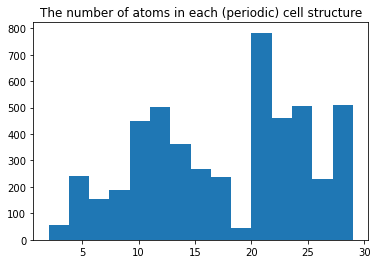

In [15]:
strucLenList = [len(datum) for datum in newAtoms]
plt.hist(strucLenList, bins=15);
plt.title('The number of atoms in each (periodic) cell structure');

In [16]:
# we just keep the first 1000 data points for speed testing. Even this took a while.
# testdata = testdata[:1000]

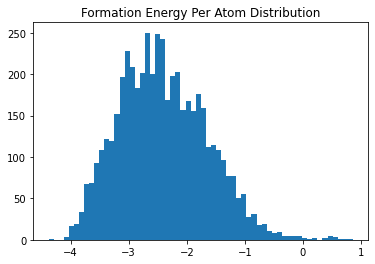

In [17]:
plt.hist(np.array(testfepa), bins =60)
plt.title('Formation Energy Per Atom Distribution');


In [18]:
fepa_list = [dict(fepa=crystalFepa) for crystalFepa in testfepa]
fepa_list[0]


{'fepa': array([-2.805527], dtype=float32)}

In [12]:
# mytestLen = int(newAtoms.shape[0]*.15)
# mytestAtoms = newAtoms[:mytestLen]
# mytestFepa = fepa_list[:mytestLen]
# newAtoms = newAtoms[mytestLen:]
# fepa_list = fepa_list[mytestLen:]

In [13]:
%rm split.npz
%rm qm9tut/lightning_logs/split.npz

trainLength = round(len(fepa_list)*.7)
valLength = round(trainLength*.2)
testLength = len(fepa_list)-(trainLength+valLength)

rm: cannot remove ‘split.npz’: No such file or directory
rm: cannot remove ‘qm9tut/lightning_logs/split.npz’: No such file or directory


In [14]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    a1 = a[p]
    b1 = b[p]
    return a1,b1

In [15]:
np.random.seed(42)
fepa_array, newAtoms = unison_shuffled_copies(np.array(fepa_list), newAtoms)

In [16]:
fepaTest = fepa_array[:testLength//2]
atomsTest = newAtoms[:testLength//2]
# here we separate the first half of the data to use as test data in a "manual" operation. 
# Schnet takes its own test data automatically from the train data below.
fepaTrain = fepa_array[testLength//2:]
atomsTrain = newAtoms[testLength//2:]


In [17]:
datapth = './new_dataset.db'
%rm {datapth}
%rm qm9tut/lightning_logs/best_inference_model

new_dataset = ASEAtomsData.create(datapth, 
                                  distance_unit='Ang',
                                  property_unit_dict={'fepa':'eV',}                                  
                        # environment_provider= spk.environment.AseEnvironmentProvider(5)
                        )


rm: cannot remove ‘qm9tut/lightning_logs/best_inference_model’: No such file or directory


In [18]:
type(new_dataset)

schnetpack.data.atoms.ASEAtomsData

In [19]:
# new_dataset.add_systems(fepa_list, newAtoms)
new_dataset.add_systems(fepaTrain, atomsTrain)  #here we don't feed the testset to data loader.

In [20]:
for p in new_dataset.available_properties:
    print('-', p)
print()

example = new_dataset[0]
print('Properties of molecule with id 0:')

for k, v in example.items():
    print('-', k, ':', v.shape)

- fepa

Properties of molecule with id 0:
- _idx : torch.Size([1])
- fepa : torch.Size([1])
- _n_atoms : torch.Size([1])
- _atomic_numbers : torch.Size([16])
- _positions : torch.Size([16, 3])
- _cell : torch.Size([1, 3, 3])
- _pbc : torch.Size([3])


In [21]:
qm9tut = './qm9tut/lightning_logs'
if not os.path.exists('qm9tut/lightning_logs'):
    os.makedirs(qm9tut)


In [22]:
crysData = AtomsDataModule(datapath=datapth,
                   batch_size=20,
                #    batch_size=100,
    num_train=trainLength,
    num_val=valLength,
    transforms=[
        trn.ASENeighborList(cutoff=5.),
        # trn.RemoveOffsets('fepa', remove_mean=True, remove_atomrefs=True),
        trn.CastTo32()
    ],
    property_units={'fepa': 'eV'},
    num_workers=1,
    split_file=os.path.join(qm9tut, "split.npz"),
    pin_memory=True, # set to false, when not using a GPU
    load_properties=['fepa'], #only load U0 property
    )

In [23]:
crysData.prepare_data()
crysData.setup()

In [24]:
print("The total length of the data set is", len(new_dataset))
print("The length of the training set is", trainLength)
print("The length of the validation set is", valLength)
print("The length of the test set is", len(new_dataset)-(trainLength+valLength))

The total length of the data set is 4595
The length of the training set is 3496
The length of the validation set is 699
The length of the test set is 400


In [25]:
# atomrefs = crysData.train_dataset.atomrefs
# atomrefs

In [26]:
means, stddevs = crysData.get_stats(
    'fepa', divide_by_atoms=True, remove_atomref=True
)
print('Mean atomization energy / atom:', means.item())
print('Std. dev. atomization energy / atom:', stddevs.item())
# This doesn't work when no test data is given, and it has no docstring. Does it calculate the mean and and std of test data?

100%|██████████| 175/175 [01:23<00:00,  2.10it/s]

Mean atomization energy / atom: -0.17984391218669357
Std. dev. atomization energy / atom: 0.15125992693674378


In [27]:
cutoff = 5
radial_basis = spk.nn.GaussianRBF(n_rbf=20, cutoff=cutoff)
n_atom_basis = 30
n_filters = 64

In [28]:
pairwise_distance = spk.atomistic.PairwiseDistances() # calculates pairwise distances between atoms

In [29]:
schnet = spk.representation.SchNet(
    n_atom_basis=n_atom_basis, n_filters=n_filters, n_interactions=3, radial_basis=radial_basis,
    
    cutoff_fn = spk.nn.CosineCutoff(cutoff),
)


In [30]:
pred_fepa = spk.atomistic.Atomwise(n_in=n_atom_basis, output_key='fepa')

In [31]:
nnpot = spk.model.NeuralNetworkPotential(
    representation=schnet,
    input_modules=[pairwise_distance],
    output_modules=[pred_fepa],
    postprocessors=[trn.CastTo64(), trn.AddOffsets('fepa', add_mean=True, add_atomrefs=False)]  
)

In [32]:
output_fepa = spk.task.ModelOutput(
    name='fepa',
    loss_fn=torch.nn.MSELoss(), #this+metrics below later changes to BCELoss 
    loss_weight=1.,
    metrics={
        "MAE": torchmetrics.MeanAbsoluteError()
    }
)

In [33]:
task = spk.task.AtomisticTask(
    model=nnpot,
    outputs=[output_fepa],
    optimizer_cls=torch.optim.AdamW,
    optimizer_args={"lr": 1e-4}
)

INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmp75ntpm3w
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmp75ntpm3w/_remote_module_non_scriptable.py


In [34]:
logger = pl.loggers.TensorBoardLogger(save_dir=qm9tut)
callbacks = [
    spk.train.ModelCheckpoint(
        inference_path=os.path.join(qm9tut, "best_inference_model"),
        save_top_k=1,
        monitor="val_loss"
    )
]


In [35]:

trainer = pl.Trainer(
    # devices=2,   #error says a strategy is selected which is not compatible with interactive mode; regardless of choosing a "compatible" strategy.
    # auto_select_gpus = False,
    # gpus=[0],  #this selects the number of gpus to use, not the exact one.
    auto_select_gpus = True,
    gpus=1,  #this selects the number of gpus to use, not the exact one.
    strategy=None,
    callbacks=callbacks,
    logger=logger,
    default_root_dir=qm9tut,
    max_epochs=10, # for testing, we restrict the number of epochs
)

Auto select gpus: [0]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [36]:
# class MetricTracker(pl.callbacks.Callback):
#     def __init__(self):
#         self.val_error_batch   = []
#         self.val_error         = []
#         self.train_error_batch = []
#         self.train_error       = []

#     def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
#         self.train_error_batch.append(outputs['loss'].item())

#     def on_train_epoch_end(self, *args, **kwargs):
#         self.train_error.append(np.mean(self.train_error_batch))
#         self.train_error_batch = []

#     def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx):
#         self.val_error_batch.append(outputs['val_loss'].item())

#     def on_validation_epoch_end(self, trainer, pl_module):
#         self.val_error.append(np.mean(self.val_error_batch))
#         self.val_error_batch = []

In [37]:
# trainer.fit(task, train_dataloaders=train_loader, val_dataloaders=val_loader)#, datamodule=qm9data)
trainer.fit(task, datamodule=crysData)

100%|██████████| 175/175 [01:22<00:00,  2.11it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name    | Type                   | Params
---------------------------------------------------
0 | model   | NeuralNetworkPotential | 34.4 K
1 | outputs | ModuleList             | 0     
---------------------------------------------------
34.4 K    Trainable params
0         Non-trainable params
34.4 K    Total params
0.138     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/samariam/anaconda3/envs/schDev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 18 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/samariam/anaconda3/envs/schDev/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:72: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 20. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/home/samariam/anaconda3/envs/schDev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_w

Training: 0it [00:00, ?it/s]

/home/samariam/anaconda3/envs/schDev/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:72: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Validation: 0it [00:00, ?it/s]

/home/samariam/anaconda3/envs/schDev/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:72: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 19. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [38]:
best_model = torch.load(os.path.join(qm9tut, 'best_inference_model'))

In [39]:
trainer.test(task, crysData)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/home/samariam/anaconda3/envs/schDev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 18 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_fepa_MAE       │    0.9091170430183411     │
│         test_loss         │    1.2600083351135254     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.2600083351135254, 'test_fepa_MAE': 0.9091170430183411}]

after 3 epochs: [{'test_loss': 11.951684951782227, 'test_fepa_MAE': 2.681666851043701}]

after 10 epochs: [{'test_loss': 2.2840123176574707, 'test_fepa_MAE': 1.183426022529602}]

In [20]:
# %reload_ext tensorboard
# %tensorboard --logdir=./qm9tut/lightning_logs
# this can be used to launch tensorboard on the browser and see the logs.

##### Testing with data not already seen by the dataloader

In [46]:
converter = spk.interfaces.AtomsConverter(neighbor_list=trn.ASENeighborList(cutoff=5.), dtype=torch.float32)

In [47]:
best_model = best_model.to('cpu')

In [48]:
predFepa = []
for at in atomsTest:
    inputs = converter(at)
    pred = best_model(inputs)
    predFepa.append(pred)
    

In [49]:
res = [datum['fepa'].detach().numpy() for datum in predFepa]
fepaTestVals = [datum['fepa'] for datum in fepaTest]

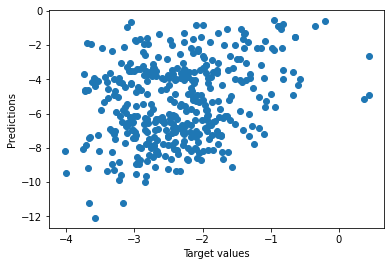

In [50]:
plt.scatter(fepaTestVals, res)
plt.xlabel("Target values");
plt.ylabel("Predictions");

In [52]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [54]:
mean_absolute_error(fepaTestVals, res)

3.146852985290763